In [1]:
import sys
sys.path.append('/home/wangs/rs/lib')
import ff
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
sns.set_palette("pastel")
from multiprocessing import Pool
from tqdm import tqdm
import statsmodels.api as sm
from datetime import datetime
import mplfinance as mpf
from functools import partial

In [2]:
import mplfinance as mpf

def event_K_line(event,n,open_,close,high,low):
    # 输入事件矩阵与天数n
    # T0到Tn-1所有事件的高开低收
    # 返回事件T0到Tn-1的平均高开低收、所有高、开、低、收 
    event_close=pd.DataFrame({'T'+str(i):(event*close.shift(-1*i,axis=1)).loc[event.index,event.columns].values.reshape(-1) for i in range(n)}).dropna()
    event_open=pd.DataFrame({'T'+str(i):(event*open_.shift(-1*i,axis=1)).loc[event.index,event.columns].values.reshape(-1) for i in range(n)}).dropna()
    event_high=pd.DataFrame({'T'+str(i):(event*high.shift(-1*i,axis=1)).loc[event.index,event.columns].values.reshape(-1) for i in range(n)}).dropna()
    event_low=pd.DataFrame({'T'+str(i):(event*low.shift(-1*i,axis=1)).loc[event.index,event.columns].values.reshape(-1) for i in range(n)}).dropna()
    w0=pd.DataFrame({'T'+str(i):event_open.loc[:,'T0'] for i in range(n)})
    mean_event=pd.DataFrame({'open':(event_open/w0).mean(),'close':(event_close/w0).mean(),'high':(event_high/w0).mean(),'low':(event_low/w0).mean()})
    # mean_event.index=pd.to_datetime(['20200101','20200102','20200103','20200104','20200105']) #便于利用mplfinance画图
    return mean_event,event_close,event_open,event_high,event_low

In [16]:
def daily_K_line(event,n,open,close,high,low):
    # 日均事件K线
    T0open=event*open  # 以T0open作为基准
    pre_close = event * close.shift(axis = 1)
    data=pd.DataFrame(columns=['T'+str(j) for j in range(n)])
    for j in range(n):
        _open=(event*open.shift(-j,axis=1))/T0open
        _close=(event*close.shift(-j,axis=1))/pre_close
        _low=(event*low.shift(-j,axis=1))/T0open
        _high=(event*high.shift(-j,axis=1))/pre_close
        lst=[_open.mean().mean(),_close.mean().mean(),_low.mean().mean(),_high.mean().mean()]
        data['T'+str(j)]=lst
    data.index=['open','close','low','high']
    data=data.T
    data.index=pd.to_datetime(['20200101','20200102','20200103','20200104','20200105'])
    print(data)
    mpf.plot(data,type='candle',style='default')
    return data

#### 非ST首次涨停(10%)事件的“5日K线图”和“5日分钟累计收益率曲线图”

In [7]:
judge = ((ff.read('up')*ff.filter0).loc[:,'20200102':]).cumsum(axis=1)
result = judge.where(judge.eq(1.0),np.nan)
# result = result.shift(axis = 1)
result.loc[result.index.str.startswith('300'), :] = np.nan
result.loc[result.index.str.startswith('688'), :] = np.nan
result.loc[result.index.str.endswith('BJ'), :] = np.nan

        open     close       low      high
T0  1.000000  1.097078  0.991970  1.097078
T1  1.120199  1.122033  1.079282  1.166315
T2  1.116589  1.120801  1.082768  1.161198
T3  1.114327  1.115984  1.082233  1.152710
T4  1.109897  1.112713  1.078676  1.147270


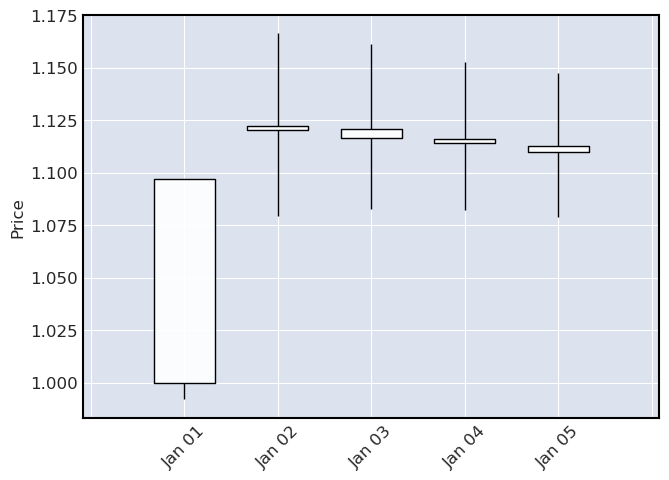

,open,close,low,high
2020-01-01,1.000000,1.097078,0.991970,1.097078
2020-01-02,1.120199,1.122033,1.079282,1.166315
2020-01-03,1.116589,1.120801,1.082768,1.161198
2020-01-04,1.114327,1.115984,1.082233,1.152710
2020-01-05,1.109897,1.112713,1.078676,1.147270


In [8]:
open = ff.read('open')*ff.read('post').loc[:,'20200102':]
close = ff.read('close')*ff.read('post').loc[:,'20200102':]
high = ff.read('high')*ff.read('post').loc[:,'20200102':]
low = ff.read('low')*ff.read('post').loc[:,'20200102':]
daily_K_line(result,5,open,close,high,low)

                open     close       low      high
2020-01-01  1.000000  1.171309  0.990975  1.171309
2020-01-02  1.170244  1.195588  1.111268  1.265415
2020-01-03  1.159793  1.192579  1.111389  1.250782
2020-01-04  1.154174  1.185291  1.111778  1.237738
2020-01-05  1.150706  1.188582  1.113695  1.238385


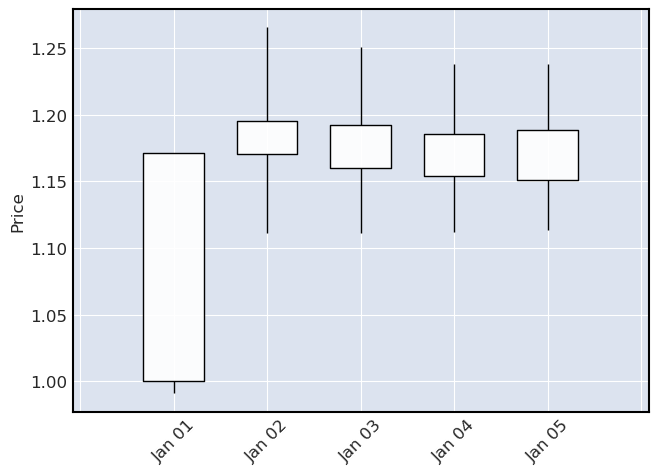

,open,close,low,high
2020-01-01,1.000000,1.171309,0.990975,1.171309
2020-01-02,1.170244,1.195588,1.111268,1.265415
2020-01-03,1.159793,1.192579,1.111389,1.250782
2020-01-04,1.154174,1.185291,1.111778,1.237738
2020-01-05,1.150706,1.188582,1.113695,1.238385


In [18]:
judge = ((ff.read('up')*ff.filter0).loc[:,'20200102':]).cumsum(axis=1)
result = judge.where(judge.eq(1.0),np.nan)
filtered_index = result.index.str.startswith('300') | result.index.str.startswith('688') | result.index.str.endswith('BJ')
result.loc[~filtered_index,:] = np.nan
open = ff.read('open')*ff.read('post').loc[:,'20200102':]
close = ff.read('close')*ff.read('post').loc[:,'20200102':]
high = ff.read('high')*ff.read('post').loc[:,'20200102':]
low = ff.read('low')*ff.read('post').loc[:,'20200102':]
daily_K_line(result,5,open,close,high,low)

在涨停板过后的一天的集合竞价往往会拉升股票，第二天开盘价往往会高开

#### 科创板，创业板，北交所

In [12]:
a = ff.read_min('000001.SZ').iloc[:,0:2]
min_list = ff.read('up').loc[:,'20200102':].idxmax(axis = 1).dropna()

In [13]:
def five_day_rets(n):
    min_list = ff.read('up').loc[:,'20200102':'20240306'].idxmax(axis = 1).dropna() 
    stock_list = min_list.index
    date_list = min_list.values
    stock = stock_list[n]
    date = date_list[n]
    ret = ff.read_min(stock).iloc[:,0:2]
    formatted_date_list = [dt.strftime('%Y%m%d') for dt in pd.to_datetime(ret.index)]
    ret.insert(0, 'Date', formatted_date_list)
    grouped = ret.groupby(ret['Date'])
    key = [key for key,value in grouped]
    day_list = key[key.index(date):key.index(date)+6]
    fiveday = pd.Series(240)
    # open = grouped.get_group(day_list[0])[:].iloc[0,1]
    for i in range(1,len(day_list)):
        a = grouped.get_group(day_list[i])[:]
        #用所有的价格除以涨停日的收盘价-1，不用cumsum
        close = grouped.get_group(day_list[0])[:].iloc[-1,2]
        a.insert(1,stock,(a.iloc[:,2]/close)-1)
        #每分钟close/上一分钟close=每分钟收益率，第一天除的前一天的收盘价格
        # close = grouped.get_group(day_list[i-1])[:].iloc[-1,2]
        # a.insert(1,stock,(a.iloc[:,2]/a.iloc[:,1]-1))
        # a.iloc[0,1] = a.iloc[0,3]/close - 1
        a.drop(columns=['Date','open','close'], inplace=True)
        a.index = np.arange(240)
        fiveday = pd.concat([fiveday,a],axis = 1)
    fiveday = fiveday.drop(columns=fiveday.columns[0])
    fiveday.columns = [0,1,2,3,4]
    return fiveday

In [14]:
from multiprocessing import Pool
min_list = ff.read('up').loc[:,'20200102':'20240305'].idxmax(axis = 1).dropna()
with Pool(48) as p:
    mean = list(tqdm(p.imap(five_day_rets, range(len(min_list))), total=len(min_list)))

100%|█████████████████████████████████████████████████████████████████████████████████████████| 4389/4389 [01:57<00:00, 37.27it/s]


In [15]:
sum_all = pd.DataFrame(0, index=range(240), columns=range(5))
# for i in tqdm(range(len(mean))):
for i in tqdm(range(len(mean))):
    sum_all+=mean[i]
ret_mean = sum_all/len(mean)

100%|███████████████████████████████████████████████████████████████████████████████████████| 4389/4389 [00:01<00:00, 2859.72it/s]


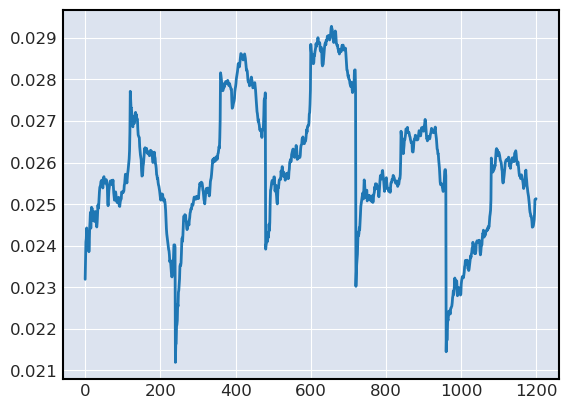

In [16]:
plt.plot(ret_mean.T.values.flatten())

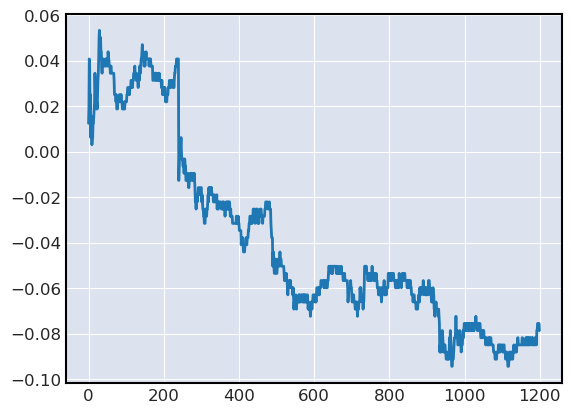

In [17]:
plt.plot(five_day_rets(3).T.values.flatten())

Daily方式（这个方式主要的特点在于对于当日涨停的，会先进行平均，然后再将所有的日期进行平均）

In [22]:
def res_min(i,stock_list,min_list):
    a = (ff.read_min(stock_list[i]).iloc[:,1]/ff.read_min(stock_list[i]).iloc[:,1].shift(1)-1).fillna(0) #计算出每一分钟的收益率
    formatted_date_list = [dt.strftime('%Y%m%d') for dt in pd.to_datetime(a.index)] #生成所有的分钟时间index
    time= min_list[stock_list[i]] #返回每支股票首次涨停的时间
    time_start = formatted_date_list.index(time) 
    return a.iloc[time_start+240:time_start+1440].values #筛选每支股票首次涨停的1200行数据

def daily_ret_min(filter):  #输入需要的event矩阵
    judge = (filter.loc[:,'20200102':'20240305']).cumsum(axis=1)
    result = judge.where(judge.eq(1.0),np.nan)
    min_list = result.loc[:,'20200102':'20240305'].idxmax(axis = 1).dropna()  #每支股票和首次涨停的时间矩阵
    stock_list = min_list.index
    grouped = min_list.groupby(min_list)  #按照日期进行分类，得到每一天有哪些股票涨停
    formatted_date_list = [dt.strftime('%Y%m%d') for dt in pd.to_datetime(ff.read_min('000001.SZ').iloc[:,2].index)]
    temp_list1 = stock_list
    temp_list2 = min_list
    with Pool(48) as p:
        partial_res_min = partial(res_min, stock_list = temp_list1,min_list = temp_list2)
        mean = list(tqdm(p.imap(partial_res_min, range(len(stock_list))), total=len(stock_list)))
    stock_list = (min_list.index).to_list()
    five_day_base = np.zeros(1200)
    for time in list(set(min_list.values)):
        time_stock = list(grouped.get_group(time).index)
        base = np.zeros(1200)
        positions = [stock_list.index(x) if x in stock_list else None for x in time_stock]
        for i in positions:
            base += mean[i]
        five_day_mean = base/len(positions)
        five_day_base+=five_day_mean
    ret_cum = np.array(five_day_base/len(list(set(min_list.values))))
    plt.plot(ret_cum.cumsum())

In [23]:
min_data = ff.read_min('000001.SZ').iloc[:,2]/ff.read_min('000001.SZ').iloc[:,2].shift(1)
judge = ((ff.read('up')*ff.filter0).loc[:,'20200102':'20240305']).cumsum(axis=1)
result = judge.where(judge.eq(1.0),np.nan)
# result = result.shift(axis = 1)
result.loc[result.index.str.startswith('300'), :] = np.nan
result.loc[result.index.str.startswith('688'), :] = np.nan
result.loc[result.index.str.endswith('BJ'), :] = np.nan
filter_ord = result

100%|█████████████████████████████████████████████████████████████████████████████████████████| 3249/3249 [01:16<00:00, 42.61it/s]


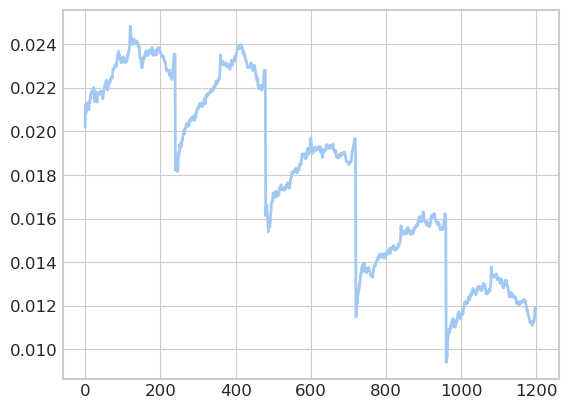

In [24]:
daily_ret_min(ff.read('up') * filter_ord)

        open     close       low      high
T0  1.000000  1.096600  0.991941  1.096600
T1  1.119590  1.121595  1.078800  1.165640
T2  1.116307  1.120586  1.082482  1.161014
T3  1.114122  1.115739  1.082006  1.152522
T4  1.109787  1.112650  1.078552  1.147215


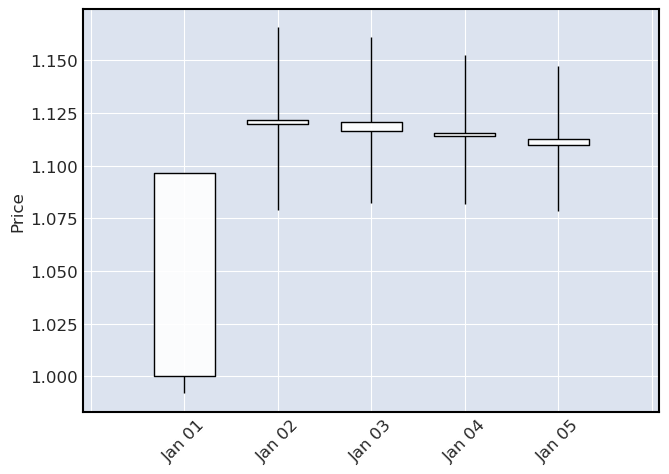

,open,close,low,high
2020-01-01,1.000000,1.096600,0.991941,1.096600
2020-01-02,1.119590,1.121595,1.078800,1.165640
2020-01-03,1.116307,1.120586,1.082482,1.161014
2020-01-04,1.114122,1.115739,1.082006,1.152522
2020-01-05,1.109787,1.112650,1.078552,1.147215


In [25]:
daily_K_line(ff.read('up') * filter_ord,5,open,close,high,low)

一个更快的办法是res_min的时候把时间作为index包含在内，然后concat的时候相同的日期的值会直接合并成一个dataframe之下，然后再对合并大list中的每一项进行平均即可

#### 科创版和st

In [36]:
filter_st_up = ((ff.read('up_limit')*ff.read('post')/(ff.read('close')*ff.read('post')).shift(axis = 1)-1)<0.055).replace({True:1,False:np.nan}) * ff.if_new * ff.if_trade
filter_st_down = ((ff.read('close')*ff.read('post')/(ff.read('close')*ff.read('post')).shift(axis = 1)-1)>0.049).replace({True:1,False:np.nan}) * ff.if_new * ff.if_trade
filter_st = filter_st_up * filter_st_down
filter_st
judge = ((filter_st).loc[:,'20200102':]).cumsum(axis=1)
filter_st = judge.where(judge.eq(1.0),np.nan)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 368/368 [00:15<00:00, 23.41it/s]


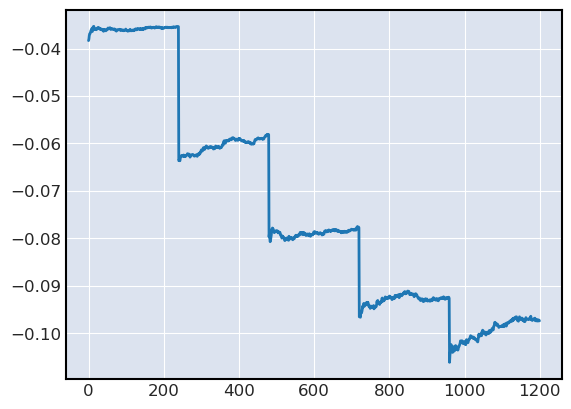

In [35]:
daily_ret_min(filter_st)

                open     close       low      high
2020-01-01  1.000000  0.956297  0.997420  0.960657
2020-01-02  0.961047  0.922047  0.957899  0.928772
2020-01-03  0.935424  0.902128  0.930644  0.912835
2020-01-04  0.923442  0.884082  0.912638  0.897864
2020-01-05  0.910374  0.871878  0.899434  0.887206


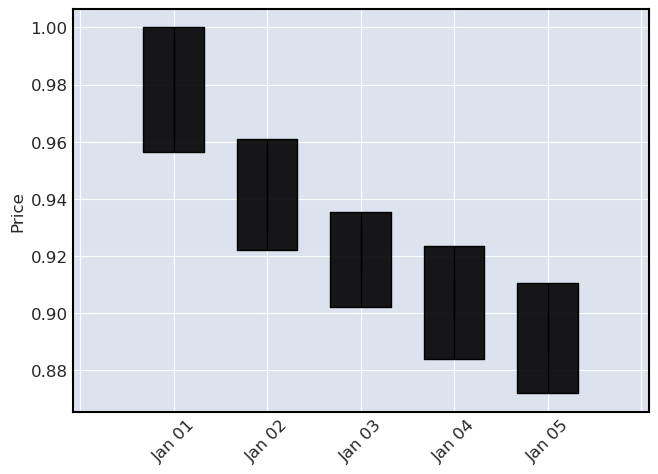

,open,close,low,high
2020-01-01,1.000000,0.956297,0.997420,0.960657
2020-01-02,0.961047,0.922047,0.957899,0.928772
2020-01-03,0.935424,0.902128,0.930644,0.912835
2020-01-04,0.923442,0.884082,0.912638,0.897864
2020-01-05,0.910374,0.871878,0.899434,0.887206


In [40]:
daily_K_line(filter_st,5,open,close,high,low)

#### 创业板

In [29]:
judge = ((ff.read('up')*ff.filter0).loc[:,'20200824':]).cumsum(axis=1) #要把daily函数改成0824
result = judge.where(judge.eq(1.0),np.nan)
filtered_index = result.index.str.startswith('300') | result.index.str.startswith('688') | result.index.str.endswith('BJ')
result.loc[~filtered_index,:] = np.nan
ff_300 = result

100%|█████████████████████████████████████████████████████████████████████████████████████████| 1140/1140 [00:26<00:00, 42.43it/s]


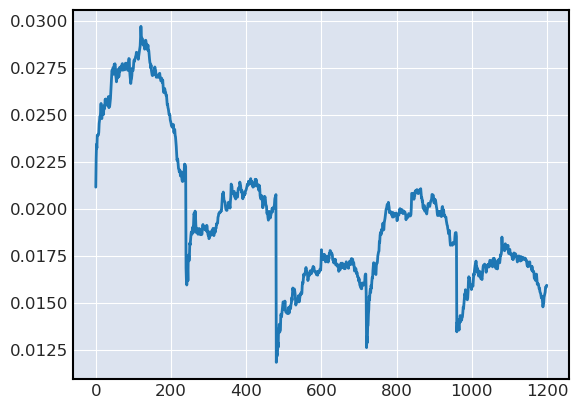

In [30]:
daily_ret_min(ff_300)

        open     close       low      high
T0  1.000000  1.140944  0.990955  1.140944
T1  1.170442  1.164412  1.111411  1.232420
T2  1.159969  1.161462  1.111594  1.218112
T3  1.154174  1.154610  1.111778  1.205609
T4  1.150706  1.157676  1.113695  1.206265


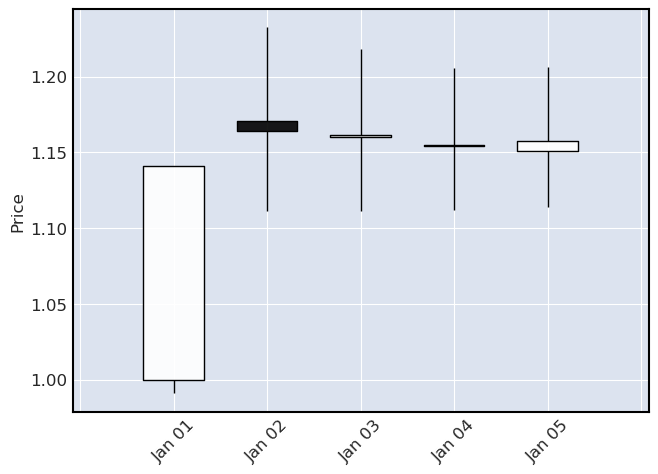

,open,close,low,high
2020-01-01,1.000000,1.140944,0.990955,1.140944
2020-01-02,1.170442,1.164412,1.111411,1.232420
2020-01-03,1.159969,1.161462,1.111594,1.218112
2020-01-04,1.154174,1.154610,1.111778,1.205609
2020-01-05,1.150706,1.157676,1.113695,1.206265


In [31]:
daily_K_line(ff_300,5,open,close,high,low)

In [2]:
filter_first_up = ((ff.read('up').shift(1,axis = 1).replace({1:0,np.nan:1})) * ff.read('up')).replace({0:np.nan})*ff.filter0
filtered_index = filter_first_up.index.str.startswith('300') | filter_first_up.index.str.startswith('688') | filter_first_up.index.str.endswith('BJ')
filter_first_up.loc[filtered_index,:] = np.nan
filter_first_up = filter_first_up.loc[:,'20200102':'20240305']
# daily_K_line(filter_first_up,5,open,close,high,low)

In [3]:
def stock_ret_mean(i):
    day = filter_first_up.columns[i]
    stock_ret_list = []
    for i in range(len(filter_first_up.loc[:,day].dropna().index)):
        stock = filter_first_up.loc[:,day].dropna().index[i]
        formatted_date_list = [dt.strftime('%Y%m%d') for dt in pd.to_datetime(ff.read_min(stock).index)] #生成所有的分钟时间index
        time_start = formatted_date_list.index(day) 
        stock_ret_list.append((ff.read_min(stock).iloc[time_start+240:time_start+1440,1]/ff.read_min(stock).iloc[time_start+239,1]).values)
    ret_aver = np.mean(stock_ret_list, axis=0)
    return ret_aver

In [5]:
ret_mean = []
with Pool(48) as p:
    ret_mean = list(tqdm(p.imap(stock_ret_mean, range(len(filter_first_up.columns))), total=len(filter_first_up.columns)))

100%|█████████████████████████████████████████████████████████████████████████████████████████| 1010/1010 [24:51<00:00,  1.48s/it]


In [6]:
mean = np.mean(ret_mean,axis = 0)

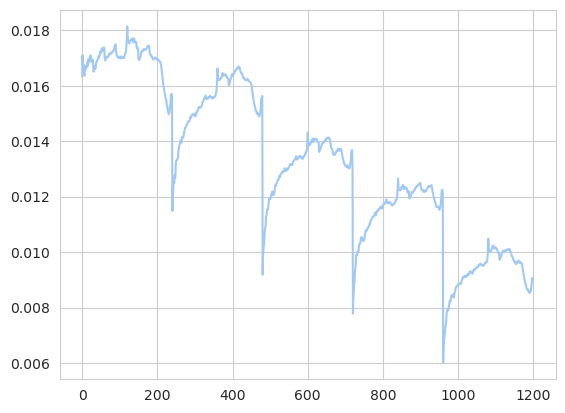

In [7]:
plt.plot(mean-1)

In [8]:
filter_st_up = ((ff.read('up_limit')*ff.read('post')/(ff.read('close')*ff.read('post')).shift(axis = 1)-1)<0.055).replace({True:1,False:np.nan}) * ff.if_new * ff.if_trade
filter_st_down = ((ff.read('close')*ff.read('post')/(ff.read('close')*ff.read('post')).shift(axis = 1)-1)>0.049).replace({True:1,False:np.nan}) * ff.if_new * ff.if_trade
filter_st = filter_st_up * filter_st_down # st股票涨停日期矩阵

In [10]:
filter_first_up = ((filter_st.shift(-1,axis = 1).replace({1:0,np.nan:1})) * filter_st).replace({0:np.nan})
filter_first_up = ((filter_st.shift(1,axis = 1).replace({1:0,np.nan:1})) * filter_first_up).replace({0:np.nan})
filter_first_up = filter_first_up.loc[:,'20200102':'20240305']

In [11]:
def stock_ret_mean(i):
    day = filter_first_up.columns[i]
    stock_ret_list = []
    for i in range(len(filter_first_up.loc[:,day].dropna().index)):
        if len(filter_first_up.loc[:,day].dropna().index) == 0:
            pass
        stock = filter_first_up.loc[:,day].dropna().index[i]
        formatted_date_list = [dt.strftime('%Y%m%d') for dt in pd.to_datetime(ff.read_min(stock).index)] #生成所有的分钟时间index
        time_start = formatted_date_list.index(day) 
        stock_ret_list.append((ff.read_min(stock).iloc[time_start+240:time_start+1440,1]/ff.read_min(stock).iloc[time_start+239,1]).values)
    ret_aver = np.mean(stock_ret_list, axis=0)
    return ret_aver

In [12]:
ret_st_mean = []
with Pool(48) as p:
    ret_st_mean = list(tqdm(p.imap(stock_ret_mean, range(len(filter_first_up.columns))), total=len(filter_first_up.columns)))

100%|█████████████████████████████████████████████████████████████████████████████████████████| 1010/1010 [02:40<00:00,  6.29it/s]


In [13]:
mean_without_nan = [arr[~np.isnan(arr)] for arr in ret_st_mean]
mean_without_nan = [arr for arr in mean_without_nan if len(arr) > 0]

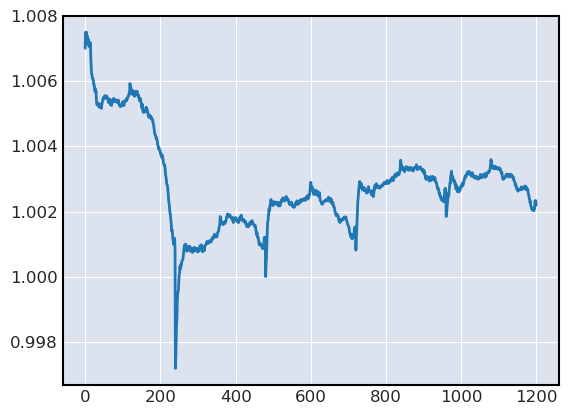

In [22]:
mean = np.mean(mean_without_nan,axis = 0)
plt.plot(mean)

                open     close       low      high
2020-01-01  1.000000  1.050427  0.991456  1.050434
2020-01-02  1.050851  1.051289  1.022938  1.082812
2020-01-03  1.040115  1.051968  1.019945  1.075701
2020-01-04  1.042938  1.052106  1.022632  1.075993
2020-01-05  1.044051  1.053568  1.023817  1.076340


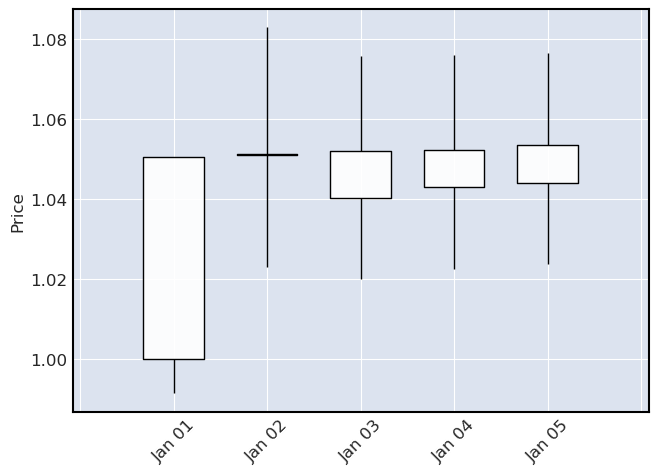

,open,close,low,high
2020-01-01,1.000000,1.050427,0.991456,1.050434
2020-01-02,1.050851,1.051289,1.022938,1.082812
2020-01-03,1.040115,1.051968,1.019945,1.075701
2020-01-04,1.042938,1.052106,1.022632,1.075993
2020-01-05,1.044051,1.053568,1.023817,1.076340


In [19]:
daily_K_line(filter_first_up,5,open,close,high,low)